# Imports and setup

In [13]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision import transforms
from tqdm import tqdm
import math
import sys
import os
import matplotlib.pyplot as plt

In [2]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/master/ml'
else:
    BASE_DIR = '.'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model code

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size=3, stride=1, padding=1, dropout=None,
                 pad_type='zero', dropout_pos='CDBR'):
        super().__init__()
        self.dropout_pos = dropout_pos
        if pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'reflect':
            # [!] the paper used reflect padding - just for data augmentation?
            self.pad = nn.ReflectionPad2d(padding)
        else:
            raise ValueError(pad_type)

        self.conv = nn.Conv2d(C_in, C_out, kernel_size, stride, padding=0, bias=False)
        if dropout is not None and dropout > 0.:
            self.dropout = nn.Dropout2d(p=dropout, inplace=True)
        else:
            self.dropout = None
        self.bn = nn.BatchNorm2d(C_out)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        if self.dropout_pos == 'CDBR' and self.dropout:
            out = self.dropout(out)
        out = self.bn(out)
        out = F.relu_(out)
        if self.dropout_pos == 'CBRD' and self.dropout:
            out = self.dropout(out)

        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, C_in, C_out, p_ldrop, p_dropout, pad_type='zero',
                 doubling=False, dropout_pos='CDBR'):
        super().__init__()

        self.n_columns = n_columns
        self.p_ldrop = p_ldrop
        self.dropout_pos = dropout_pos
        if dropout_pos == 'FD' and p_dropout > 0.:
            self.dropout = nn.Dropout2d(p=p_dropout)
            p_dropout = 0.
        else:
            self.dropout = None

        if doubling:
            self.doubler = ConvBlock(C_in, C_out, 1, padding=0)
        else:
            self.doubler = None

        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns-1)

        dist = self.max_depth
        self.count = np.zeros([self.max_depth], dtype=np.int32)
        for col in self.columns:
            for i in range(self.max_depth):
                if (i+1) % dist == 0:
                    first_block = (i+1 == dist) # first block in this column
                    if first_block and not doubling:
                        # if doubling, always input channel size is C_out.
                        cur_C_in = C_in
                    else:
                        cur_C_in = C_out

                    module = ConvBlock(cur_C_in, C_out, dropout=p_dropout, pad_type=pad_type,
                                       dropout_pos=dropout_pos)
                    self.count[i] += 1
                else:
                    module = None

                col.append(module)

            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        # global drop mask
        GB = global_cols.shape[0]
        # calc gdrop cols / samples
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = np.where(gdrop_cols >= 0)[0]
        # gen gdrop mask
        gdrop_mask = np.zeros([n_cols, GB], dtype=np.float32)
        gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.

        # local drop mask
        LB = B - GB
        ldrop_mask = np.random.binomial(1, 1.-self.p_ldrop, [n_cols, LB]).astype(np.float32)
        alive_count = ldrop_mask.sum(axis=0)
        # resurrect all-dead case
        dead_indices = np.where(alive_count == 0.)[0]
        ldrop_mask[np.random.randint(0, n_cols, size=dead_indices.shape), dead_indices] = 1.

        drop_mask = np.concatenate((gdrop_mask, ldrop_mask), axis=1)
        return torch.from_numpy(drop_mask)

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) # [n_cols, B, C, H, W]

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device) # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1, 1) # unsqueeze to [n_cols, B, 1, 1, 1]
            n_alive = mask.sum(dim=0) # [B, 1, 1, 1]
            masked_out = out * mask # [n_cols, B, C, H, W]
            n_alive[n_alive == 0.] = 1. # all-dead cases
            out = masked_out.sum(dim=0) / n_alive # [B, C, H, W] / [B, 1, 1, 1]
        else:
            out = out.mean(dim=0) # no drop

        return out

    def forward(self, x, global_cols, deepest=False):
        out = self.doubler(x) if self.doubler else x
        outs = [out] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = [] # outs of current depth
            if deepest:
                st = self.n_columns - 1 # last column only

            for c in range(st, self.n_columns):
                cur_in = outs[c] # current input
                cur_module = self.columns[c][i] # current module
                cur_outs.append(cur_module(cur_in))

            # join
            #print("join in depth = {}, # of in_join = {}".format(i, len(cur_out)))
            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        if self.dropout_pos == 'FD' and self.dropout:
            outs[-1] = self.dropout(outs[-1])

        return outs[-1] # for deepest case


class FractalNet(nn.Module):
    def __init__(self, data_shape, n_columns, init_channels, p_ldrop, dropout_probs,
                 gdrop_ratio, gap=0, init='xavier', pad_type='zero', doubling=False,
                 consist_gdrop=True, dropout_pos='CDBR'):
        super().__init__()
        assert dropout_pos in ['CDBR', 'CBRD', 'FD']

        self.B = len(dropout_probs) # the number of blocks
        self.consist_gdrop = consist_gdrop
        self.gdrop_ratio = gdrop_ratio
        self.n_columns = n_columns
        C_in, H, W, n_classes = data_shape

        assert H == W
        size = H

        layers = nn.ModuleList()
        C_out = init_channels
        total_layers = 0
        for b, p_dropout in enumerate(dropout_probs):
            print("[block {}] Channel in = {}, Channel out = {}".format(b, C_in, C_out))
            fb = FractalBlock(n_columns, C_in, C_out, p_ldrop, p_dropout,
                              pad_type=pad_type, doubling=doubling, dropout_pos=dropout_pos)
            layers.append(fb)
            if gap == 0 or b < self.B-1:
                # Originally, every pool is max-pool in the paper (No GAP).
                layers.append(nn.MaxPool2d(2))
            elif gap == 1:
                # last layer and gap == 1
                layers.append(nn.AdaptiveAvgPool2d(1)) # average pooling

            size //= 2
            total_layers += fb.max_depth
            C_in = C_out
            if b < self.B-2:
                C_out *= 2 # doubling except for last block

        print("Last featuremap size = {}".format(size))
        print("Total layers = {}".format(total_layers))

        if gap == 2:
            layers.append(nn.Conv2d(C_out, n_classes, 1, padding=0)) # 1x1 conv
            layers.append(nn.AdaptiveAvgPool2d(1)) # gap
            layers.append(Flatten())
        else:
            layers.append(Flatten())
            layers.append(nn.Linear(C_out * size * size, n_classes)) # fc layer

        self.layers = layers

        # initialization
        if init != 'torch':
            initialize_ = {
                'xavier': nn.init.xavier_uniform_,
                'he': nn.init.kaiming_uniform_
            }[init]

            for n, p in self.named_parameters():
                if p.dim() > 1: # weights only
                    initialize_(p)
                else: # bn w/b or bias
                    if 'bn.weight' in n:
                        nn.init.ones_(p)
                    else:
                        nn.init.zeros_(p)

    def forward(self, x, deepest=False):
        if deepest:
            assert self.training is False
        GB = int(x.size(0) * self.gdrop_ratio)
        out = x
        global_cols = None
        for layer in self.layers:
            if isinstance(layer, FractalBlock):
                if not self.consist_gdrop or global_cols is None:
                    global_cols = np.random.randint(0, self.n_columns, size=[GB])

                out = layer(out, global_cols, deepest=deepest)
            else:
                out = layer(out)

        return out

# Load the data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

train_val_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_ds, val_ds = torch.utils.data.random_split(train_val_ds, [.9, .1])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Create the model

In [5]:
model = FractalNet(data_shape=(3,32,32,10), n_columns=4, init_channels=64, dropout_probs=[0, .1, .2, .3, .4], gdrop_ratio=.5, p_ldrop=.15)

[block 0] Channel in = 3, Channel out = 64
[block 1] Channel in = 64, Channel out = 128
[block 2] Channel in = 128, Channel out = 256
[block 3] Channel in = 256, Channel out = 512
[block 4] Channel in = 512, Channel out = 512
Last featuremap size = 1
Total layers = 40


# Main training loop

In [6]:
num_epochs = 400
file_label = 'sgd-400-cifar10'

model = model.to(DEVICE)

if os.path.exists(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'):
    model.load_state_dict(torch.load(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'))
    history = torch.load(f'{BASE_DIR}/checkpoints/history-{file_label}.pt')
else:
    history = {
        'loss': [],
        'val_loss': []
    }

milestones = [sum([int(num_epochs/(2**p)) for p in range(1, pow)]) for pow in range(2, int(math.log2(num_epochs)) + 1)]
orig_len = len(milestones)
num_epochs_completed = len(history['loss'])
milestones = list(filter(lambda y: y > 0, [x - num_epochs_completed for x in milestones]))
filtered_len = len(milestones)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), 0.02, 0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones)

for epoch in range(num_epochs_completed, num_epochs+1):
    with tqdm(train_dl, unit='batch') as tepoch:
        epoch_losses = []
        model.train()
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            correct = (out.argmax(1) == target.argmax(1)).sum().item()
            accuracy = correct / len(target)

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)
    epoch_mean_loss = sum(epoch_losses) / len(epoch_losses)
    history['loss'].append(epoch_mean_loss)

    with torch.no_grad():
        epoch_val_losses = []
        model.eval()
        for data, target in val_dl:
            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            out = model(data)
            loss = criterion(out, target)
            epoch_val_losses.append(loss.item())
        epoch_mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss'].append(epoch_mean_val_loss)

    torch.save(model.state_dict(), f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt')
    torch.save(history, f'{BASE_DIR}/checkpoints/history-{file_label}.pt')

    scheduler.step()

    print(f'done epoch {epoch} with results: loss={epoch_mean_loss}, val_loss={epoch_mean_val_loss}')

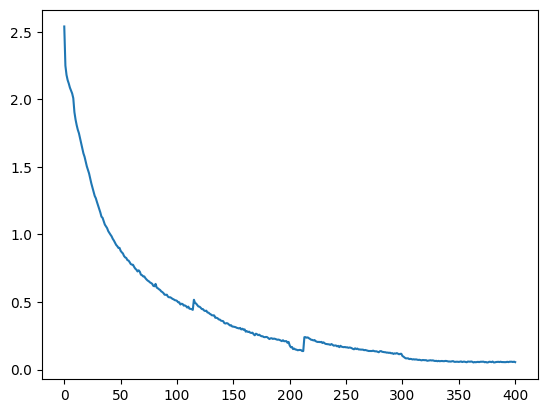

In [14]:
plt.plot(history['loss'])

In [ ]:
test_losses = []
with torch.no_grad():
    model = model.eval()
    for data, label in test_dl:
        data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)
        out = model(data)
        loss = criterion(out, label)
        test_lo.append(loss.item())
